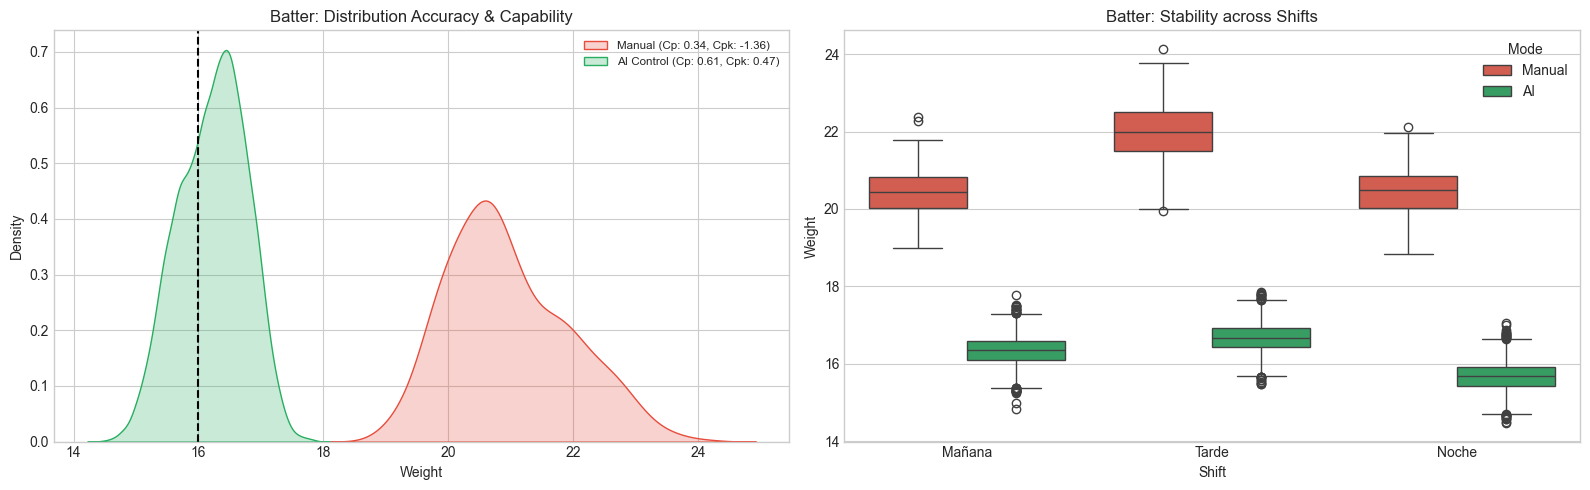

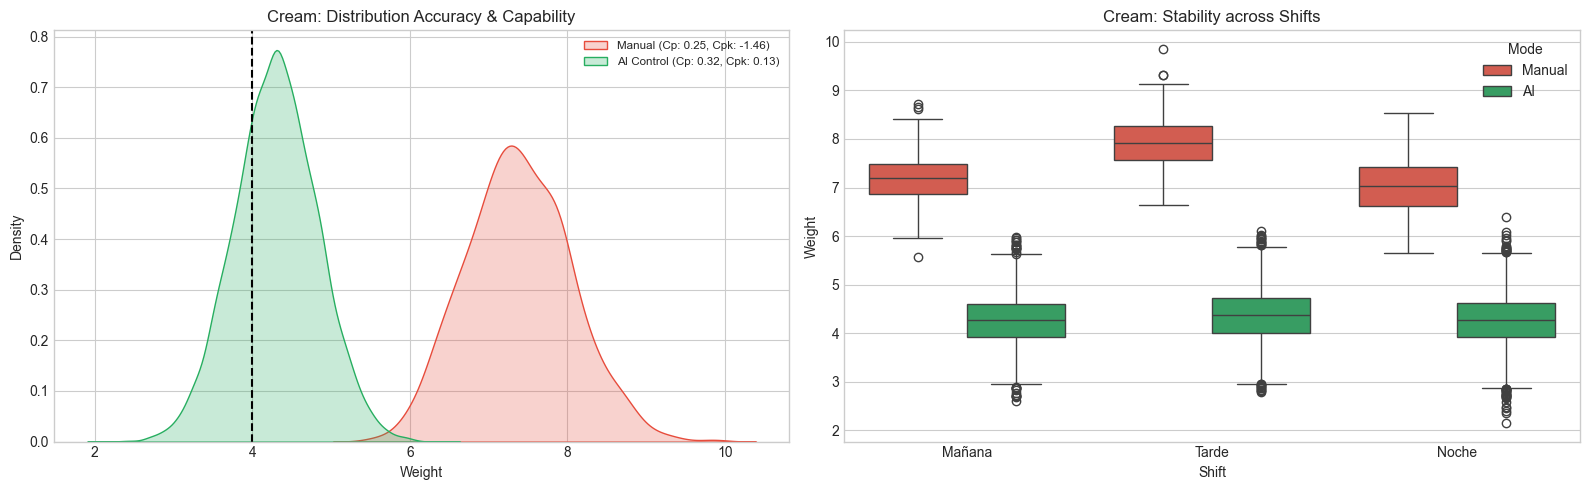

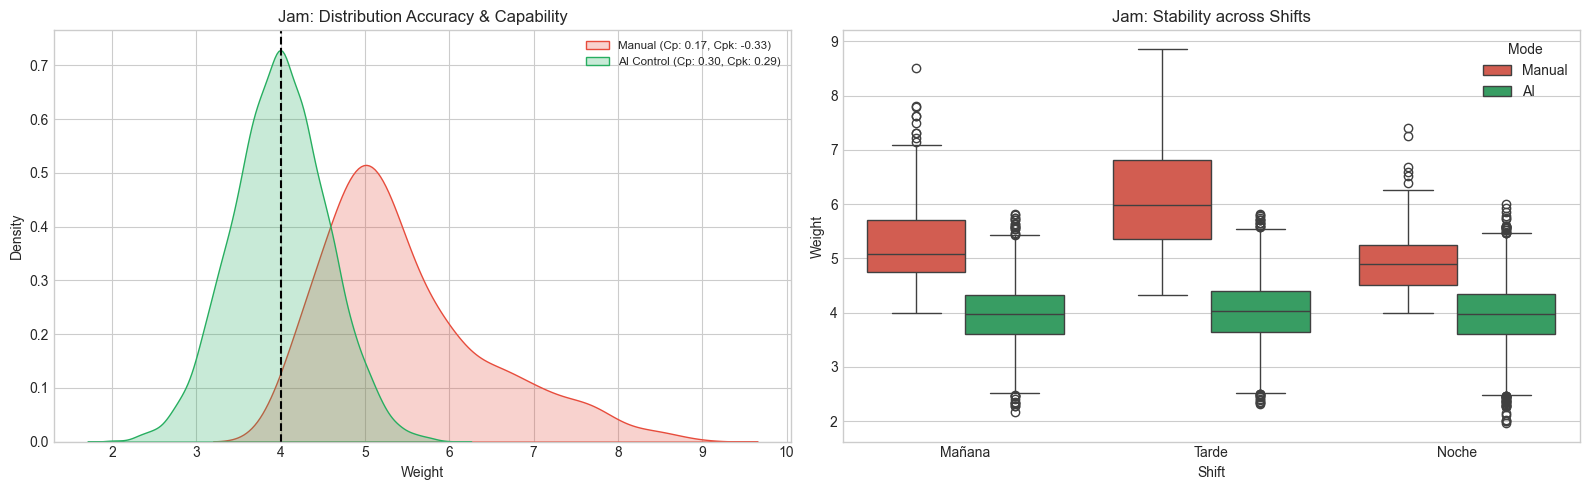

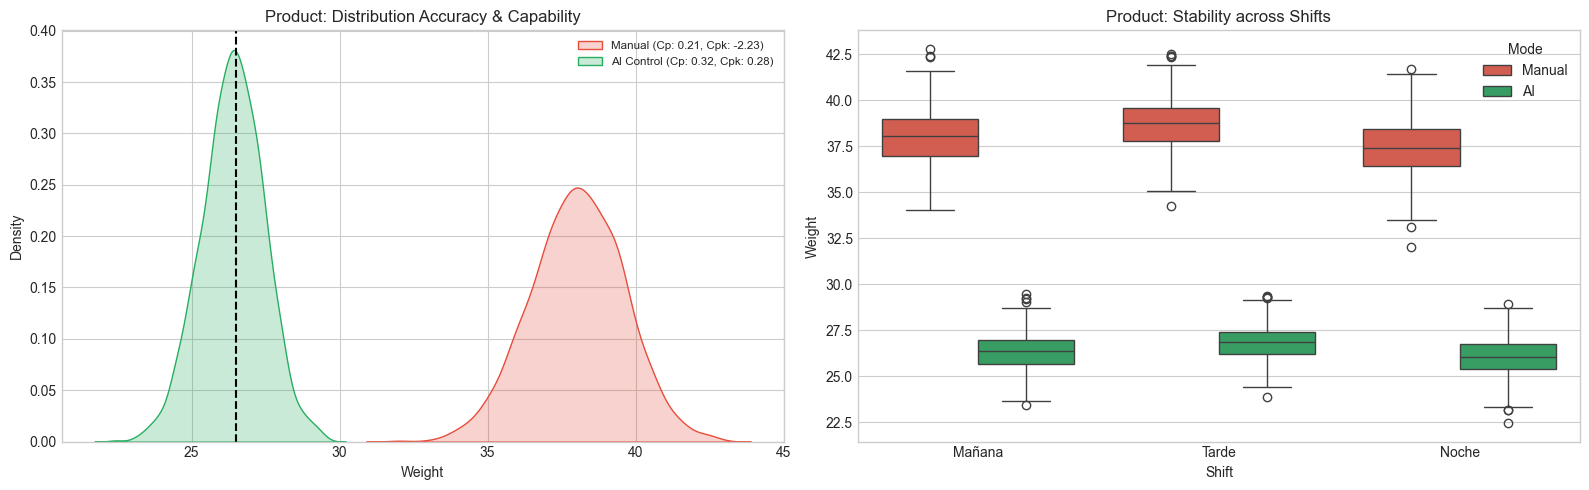

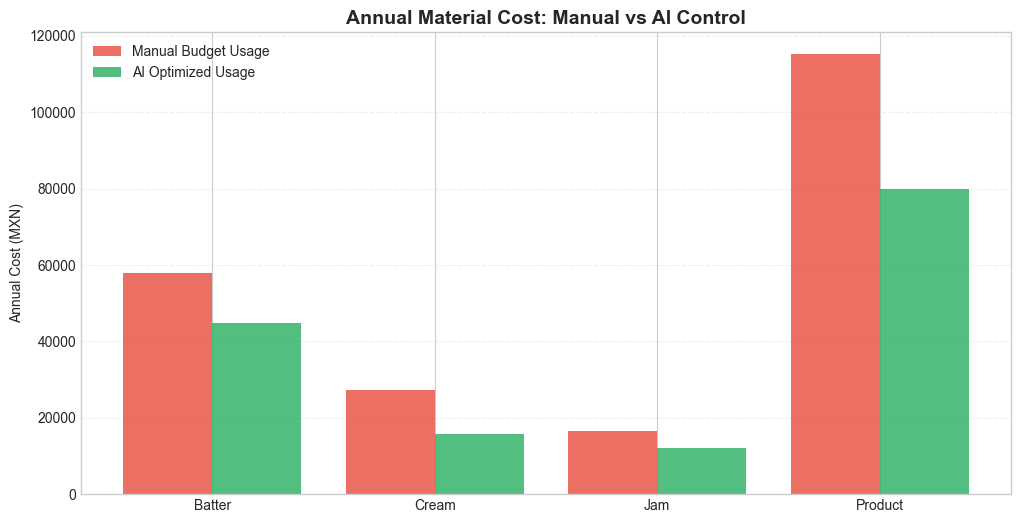

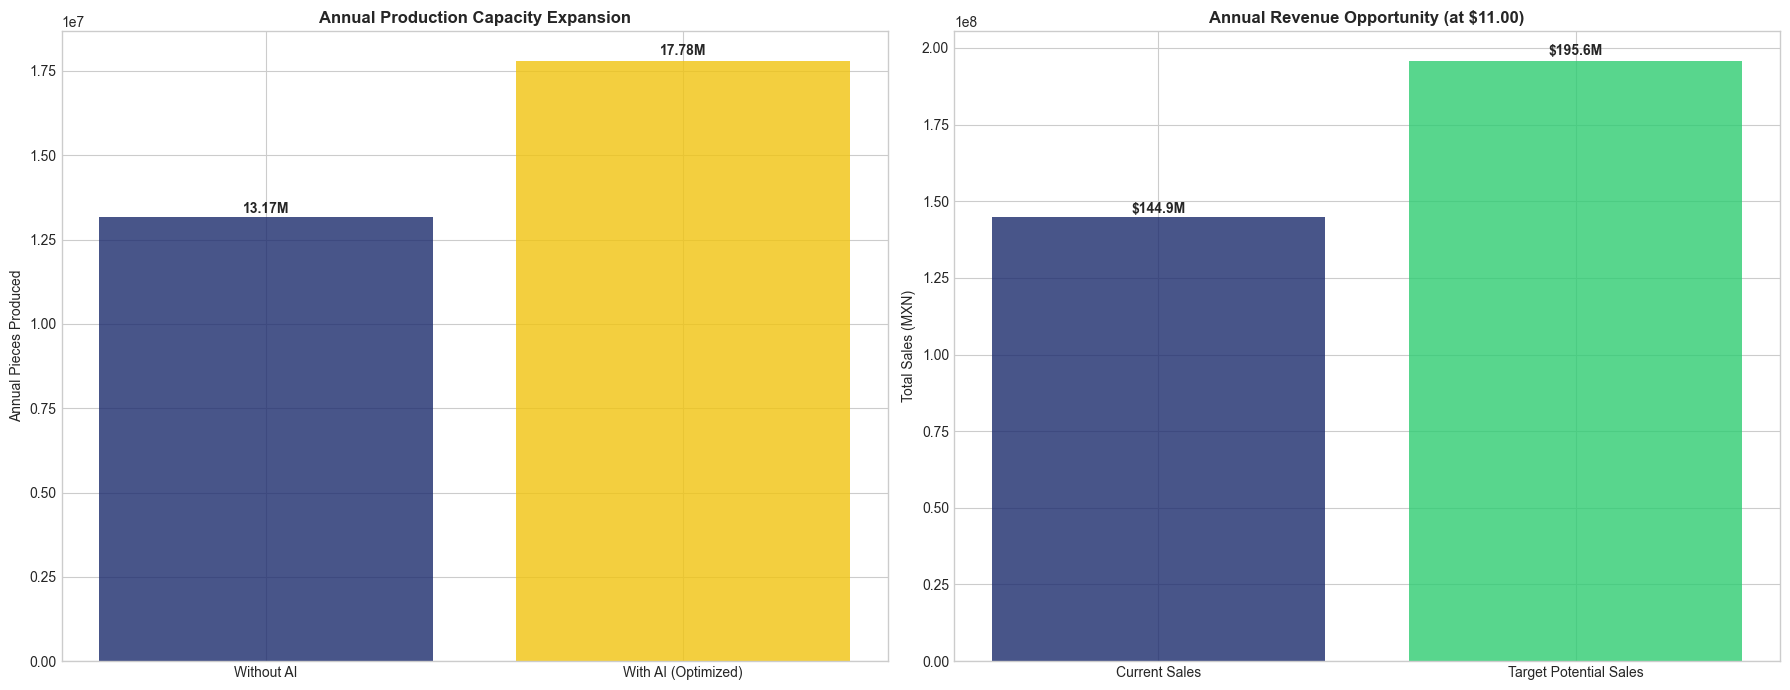


[SUCCESS] FINAL MASTER REPORT GENERATED: /reports/Master_Impact_Report_Final.html


In [32]:
# ==========================================
# 07: STRATEGIC AI IMPACT & REVENUE EXPANSION 
# AUTHOR: LARRY EDUARDO BERESFORD DÍAZ
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from IPython.display import display, HTML

# --- 1. GLOBAL STRATEGIC PARAMETERS ---
PPM = 33.5                # Average production line speed
DAYS_PER_WEEK = 5.25      # Operational schedule
WEEKS_PER_YEAR = 52
ANNUAL_PIECES = PPM * 60 * 24 * DAYS_PER_WEEK * WEEKS_PER_YEAR

RETAIL_PRICE = 11.0       # Final Store Price (MXN)
MFG_COST_PIECE = 6.0      # Reference Manufacturing Cost

# Ingredient Cost per Gram (Mass Balance logic)
COSTS = {
    'Batter':  0.21,   # Base dough
    'Jam':     0.23,   # Fruit filling
    'Cream':   0.28,   # High-value filling
    'Product': 0.23    # Finished product avg
}

SPECS = {
    'Batter':  {'target': 16.0, 'lsl': 15.0, 'usl': 17.0},
    'Cream':   {'target': 4.0,  'lsl': 3.5,  'usl': 4.5},
    'Jam':     {'target': 4.0,  'lsl': 3.5,  'usl': 4.5},
    'Product': {'target': 26.5, 'lsl': 25.5, 'usl': 27.5}
}

display(HTML(f"<h1 style='color:#1a2a6c; border-bottom:3px solid #b21f1f;'>Strategic AI Impact: Revenue & Capacity Expansion</h1>"))

# --- 2. DATA NORMALIZATION ---
data_path = '../data/'
def load_smart(file, stage):
    df = pd.read_csv(data_path + file)
    col_map = {'Peso (g)': 'Weight', 'Weight_g': 'Weight', 'turno': 'Shift', 'Turno': 'Shift'}
    df = df.rename(columns=col_map)
    df['Stage'] = stage
    if 'Shift' in df.columns: df['Shift'] = df['Shift'].str.capitalize().str.strip()
    return df

files_pre = {'Batter': 'Muestreo_Depositado_Presion.csv', 'Cream': 'Muestreo_Crema_Presion_V2.csv', 'Jam': 'Muestreo_Mermelada_Presion.csv', 'Product': 'Muestreo_PT_V2.csv'}
files_post = {'Batter': 'Muestreo_Post_Mejora_LP.csv', 'Cream': 'Muestreo_Crema_LP-3.csv', 'Jam': 'PostML_Mermelada_LP.csv', 'Product': 'Muestreo_26_5g_turnos.csv'}

# --- 3. ANALYTICS ENGINE (Including Cp & Cpk) ---
results = []
os.makedirs('../reports/assets', exist_ok=True)

for stage in SPECS.keys():
    df_pre = load_smart(files_pre[stage], stage)
    df_post = load_smart(files_post[stage], stage)
    
    m_pre, m_post = df_pre['Weight'].mean(), df_post['Weight'].mean()
    std_pre, std_post = df_pre['Weight'].std(), df_post['Weight'].std()
    lsl, usl = SPECS[stage]['lsl'], SPECS[stage]['usl']
    
    # Financial KPI Calculations
    gram_savings = max(0, m_pre - m_post)
    annual_kg_saved = (gram_savings * ANNUAL_PIECES) / 1000
    monetary_savings = annual_kg_saved * 1000 * COSTS[stage]
    
    # Quality Compliance (% of units in spec)
    compliance_pre = (len(df_pre[(df_pre['Weight'] >= lsl) & (df_pre['Weight'] <= usl)]) / len(df_pre)) * 100
    compliance_post = (len(df_post[(df_post['Weight'] >= lsl) & (df_post['Weight'] <= usl)]) / len(df_post)) * 100
    
    # Capability Indices (Cp & Cpk)
    cp_pre = (usl - lsl) / (6 * std_pre) if std_pre > 0 else 0
    cpk_pre = min((usl - m_pre)/(3*std_pre), (m_pre - lsl)/(3*std_pre)) if std_pre > 0 else 0
    
    cp_post = (usl - lsl) / (6 * std_post) if std_post > 0 else 0
    cpk_post = min((usl - m_post)/(3*std_post), (m_post - lsl)/(3*std_post)) if std_post > 0 else 0
    
    results.append({
        'Stage': stage, 'Target': SPECS[stage]['target'], 'Mean_Pre': m_pre, 'Mean_Post': m_post,
        'Savings_g': gram_savings, 'Kg_Saved': annual_kg_saved, 'ROI_Annual': monetary_savings, 
        'Cp_Pre': round(cp_pre, 2), 'Cpk_Pre': round(cpk_pre, 2),
        'Cp_Post': round(cp_post, 2), 'Cpk_Post': round(cpk_post, 2),
        'Compliance_Pre': compliance_pre, 'Compliance_Post': compliance_post, 'Accuracy': round(compliance_post, 1)
    })

    # PLOT: Distribution & Shift Variability
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # KDE Plot with Cp and Cpk in Legend
    sns.kdeplot(df_pre['Weight'], fill=True, color='#E74C3C', label=f'Manual (Cp: {cp_pre:.2f}, Cpk: {cpk_pre:.2f})', ax=axes[0])
    sns.kdeplot(df_post['Weight'], fill=True, color='#27AE60', label=f'AI Control (Cp: {cp_post:.2f}, Cpk: {cpk_post:.2f})', ax=axes[0])
    axes[0].axvline(SPECS[stage]['target'], color='black', linestyle='--')
    axes[0].set_title(f'{stage}: Distribution Accuracy & Capability')
    axes[0].legend(fontsize='small')

    df_comb = pd.concat([df_pre.assign(Mode='Manual'), df_post.assign(Mode='AI')])
    sns.boxplot(x='Shift', y='Weight', hue='Mode', data=df_comb, palette=['#E74C3C', '#27AE60'], ax=axes[1])
    axes[1].set_title(f'{stage}: Stability across Shifts')
    plt.tight_layout()
    plt.savefig(f'../reports/assets/plot_{stage.lower()}.png', bbox_inches='tight')
    plt.show()

# --- 4. FINANCIAL & STRATEGIC COMPARISON CHARTS ---
df_res = pd.DataFrame(results)
sub_processes = ['Batter', 'Cream', 'Jam']
total_annual_roi = df_res[df_res['Stage'].isin(sub_processes)]['ROI_Annual'].sum()
total_kg_saved = df_res[df_res['Stage'].isin(sub_processes)]['Kg_Saved'].sum()

# Revenue & Capacity Expansion
extra_units = (total_kg_saved * 1000) / 26.5
current_revenue = ANNUAL_PIECES * RETAIL_PRICE
potential_revenue = (ANNUAL_PIECES + extra_units) * RETAIL_PRICE

# --- CHART 1: MATERIAL BUDGET SAVINGS ---
plt.figure(figsize=(12, 6))
labels = df_res['Stage']
manual_costs = [r['Mean_Pre'] * COSTS[r['Stage']] * ANNUAL_PIECES / 1000 for _, r in df_res.iterrows()]
ai_costs = [r['Mean_Post'] * COSTS[r['Stage']] * ANNUAL_PIECES / 1000 for _, r in df_res.iterrows()]
x = np.arange(len(labels))
plt.bar(x - 0.2, manual_costs, 0.4, label='Manual Budget Usage', color='#E74C3C', alpha=0.8)
plt.bar(x + 0.2, ai_costs, 0.4, label='AI Optimized Usage', color='#27AE60', alpha=0.8)
plt.title('Annual Material Cost: Manual vs AI Control', fontweight='bold', fontsize=14)
plt.ylabel('Annual Cost (MXN)')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.savefig('../reports/assets/budget_comparison.png', bbox_inches='tight')
plt.show()

# --- CHART 2: PRODUCTION & REVENUE EXPANSION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ax1.bar(['Without AI', 'With AI (Optimized)'], [ANNUAL_PIECES, ANNUAL_PIECES + extra_units], color=['#1a2a6c', '#f1c40f'], alpha=0.8)
ax1.set_title('Annual Production Capacity Expansion', fontweight='bold')
ax1.set_ylabel('Annual Pieces Produced')
for i, v in enumerate([ANNUAL_PIECES, ANNUAL_PIECES + extra_units]):
    ax1.text(i, v + (v*0.01), f"{v/1e6:.2f}M", ha='center', fontweight='bold')

ax2.bar(['Current Sales', 'Target Potential Sales'], [current_revenue, potential_revenue], color=['#1a2a6c', '#2ecc71'], alpha=0.8)
ax2.set_title(f'Annual Revenue Opportunity (at ${RETAIL_PRICE:.2f})', fontweight='bold')
ax2.set_ylabel('Total Sales (MXN)')
for i, v in enumerate([current_revenue, potential_revenue]):
    ax2.text(i, v + (v*0.01), f"${v/1e6:.1f}M", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/assets/revenue_expansion.png', bbox_inches='tight')
plt.show()


# --- 5. EXECUTIVE DASHBOARD ---
display(HTML(f"""
<div style="background: linear-gradient(135deg, #1a2a6c, #b21f1f); color: white; padding: 40px; border-radius: 15px; text-align: center; margin-top: 20px;">
    <h1 style="margin:0;">TOTAL ANNUAL COST RECOVERY: ${total_annual_roi:,.0f} MXN</h1>
    <h2 style="color:#f1c40f;">CAPACITY GAIN: +{extra_units:,.0f} FREE UNITS PER YEAR</h2>
    <p style="font-size: 1.3em;">Incremental Revenue Potential: <b>${(potential_revenue - current_revenue):,.0f} MXN</b></p>
    <p style="font-size: 0.9em; opacity: 0.8;">Verified by Senior Analyst: Larry Eduardo Beresford Díaz</p>
</div>
"""))

# --- 6. MASTER HTML REPORT GENERATION ---
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <style>
        body {{ font-family: 'Segoe UI', sans-serif; background: #f0f2f5; margin: 0; padding: 40px; position: relative; }}
        body::before {{ content: "LARRY EDUARDO BERESFORD DÍAZ"; position: fixed; top: 50%; left: 50%; transform: translate(-50%, -50%) rotate(-45deg); font-size: 4em; color: rgba(0,0,0,0.02); z-index: -1; white-space: nowrap; pointer-events: none; }}
        .report-card {{ max-width: 1100px; margin: auto; background: white; padding: 50px; border-radius: 20px; box-shadow: 0 20px 40px rgba(0,0,0,0.1); }}
        .main-roi {{ background: linear-gradient(135deg, #1a2a6c, #b21f1f); color: white; padding: 40px; border-radius: 15px; text-align: center; margin-bottom: 40px; }}
        .kpi-grid {{ display: grid; grid-template-columns: repeat(3, 1fr); gap: 20px; margin-bottom: 40px; }}
        .kpi-item {{ background: #f8f9fa; padding: 25px; border-radius: 12px; text-align: center; border: 1px solid #eee; }}
        .kpi-val {{ font-size: 2.2em; font-weight: 900; color: #1a2a6c; }}
        .chart-img {{ width: 100%; border-radius: 10px; box-shadow: 0 5px 15px rgba(0,0,0,0.05); margin-bottom: 40px; }}
        table {{ width: 100%; border-collapse: collapse; margin-bottom: 40px; }}
        th {{ background: #1a2a6c; color: white; padding: 15px; text-transform: uppercase; font-size: 0.85em; }}
        td {{ padding: 15px; text-align: center; border-bottom: 1px solid #eee; }}
    </style>
</head>
<body>
    <div class="report-card">
        <h1 style="color:#1a2a6c; margin-bottom:0;">STRATEGIC AI IMPACT & REVENUE REPORT</h1>
        <p style="color:#7f8c8d; margin-top:5px;">Larry Eduardo Beresford Díaz | Senior Industrial Data Science Portfolio</p>

        <div class="main-roi">
            <div style="font-size: 1.2em; opacity: 0.9;">TOTAL PROJECTED REVENUE POTENTIAL</div>
            <div style="font-size: 4.5em; font-weight: 900; margin: 10px 0;">${potential_revenue/1e6:,.1f}M <span style="font-size: 0.3em;">MXN</span></div>
        </div>

        <div class="kpi-grid">
            <div class="kpi-item"><div class="kpi-val">{df_res[df_res['Stage']!='Product']['Compliance_Post'].mean():.1f}%</div><div class="kpi-label">AI Quality Compliance</div></div>
            <div class="kpi-item"><div class="kpi-val">{total_kg_saved:,.0f} kg</div><div class="kpi-label">Annual Raw Material Recovered</div></div>
            <div class="kpi-item"><div class="kpi-val">{extra_units:,.0f}</div><div class="kpi-label">Free Units Potential</div></div>
        </div>

        <h2 style="color:#1a2a6c; border-left: 5px solid #b21f1f; padding-left:15px; margin-bottom:20px;">Financial Efficiency: Budget vs Opportunity</h2>
        <img src="assets/budget_comparison.png" class="chart-img">
        <img src="assets/revenue_expansion.png" class="chart-img">

        <h2 style="color:#1a2a6c; border-left: 5px solid #b21f1f; padding-left:15px; margin-bottom:20px;">Risk Mitigation: Quality Compliance Rate</h2>
        <img src="assets/quality_compliance.png" class="chart-img">

        <table>
            <thead>
                <tr><th>Stage</th><th>Target</th><th>Cp (AI)</th><th>Cpk (AI)</th><th>Annual ROI (MXN)</th><th>Accuracy</th></tr>
            </thead>
            <tbody>
                {"".join([f"<tr><td><b>{r['Stage']}</b></td><td>{r['Target']}g</td><td>{r['Cp_Post']}</td><td>{r['Cpk_Post']}</td><td style='color:#27ae60; font-weight:bold;'>${r['ROI_Annual']:,.0f}</td><td>{r['Accuracy']}%</td></tr>" for _, r in df_res.iterrows()])}
            </tbody>
        </table>

        {"".join([f'<img src="assets/plot_{s.lower()}.png" class="chart-img">' for s in SPECS.keys()])}

        <div style="text-align:center; margin-top:80px; font-weight:bold; color:#2c3e50;">
            Larry Eduardo Beresford Díaz<br>
            <span style="font-size:0.8em; font-weight:normal; color:#7f8c8d;">Senior Data Scientist & Industrial Engineer | github.com/LarryBeresford</span>
        </div>
    </div>
</body>
</html>
"""

with open('../reports/Master_Impact_Report_Final.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\n[SUCCESS] FINAL MASTER REPORT GENERATED: /reports/Master_Impact_Report_Final.html")